This notebook produces the network topology graphs for the presentation

In [1]:
import ising_efficient
import network_generation
import sparse_adj_mat
from sparse_adj_mat import Sparse_Adjacency_Matrix
from network_generation import generate_erdos_renyi_sparse_adjacency_matrix
from network_generation import generate_scale_free_sparse_adjacency_matrix_jax
from network_generation import generate_small_world_sparse_adjacency_matrix_jax
from ising_efficient import BeliefNetwork
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from collections import deque

import numpy as np
import voronoi
import pickle

# Network topology

The three following topolgies were tested with the same network sized and average degree.

In [2]:
#shared parameters
N = 100
weight_range=(-0.04, 0.2) # weight range changed from (-1,1.0) to (-0.1, 0.2) - individuals within the network tend to agree with their neighbours 
avg_deg = 20
seed = 1

#topology parameters
#Erdos_Renyi
edge_prob = avg_deg/(N-1) 
print(edge_prob)

#Scale free - Albert Barab'asi 
new_edges = avg_deg//2 #avg_deg ~ 2m

#Small world
k_neighbours = avg_deg #k neighbours per node
rewire_prob = 0.1  #rewiring probability

#external field
alpha = 100 #time of the peak
gamma = 5 #width of the peak

µ = 1 #memory coefficient


0.20202020202020202


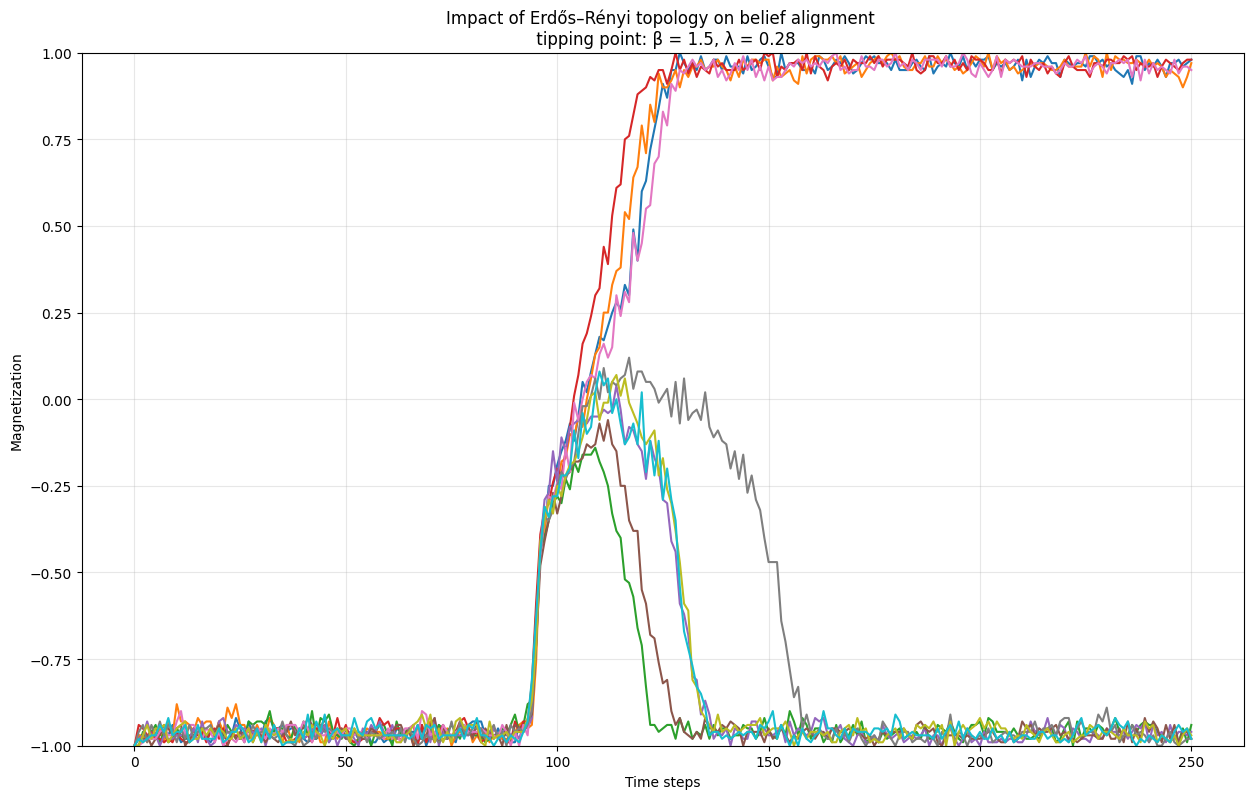

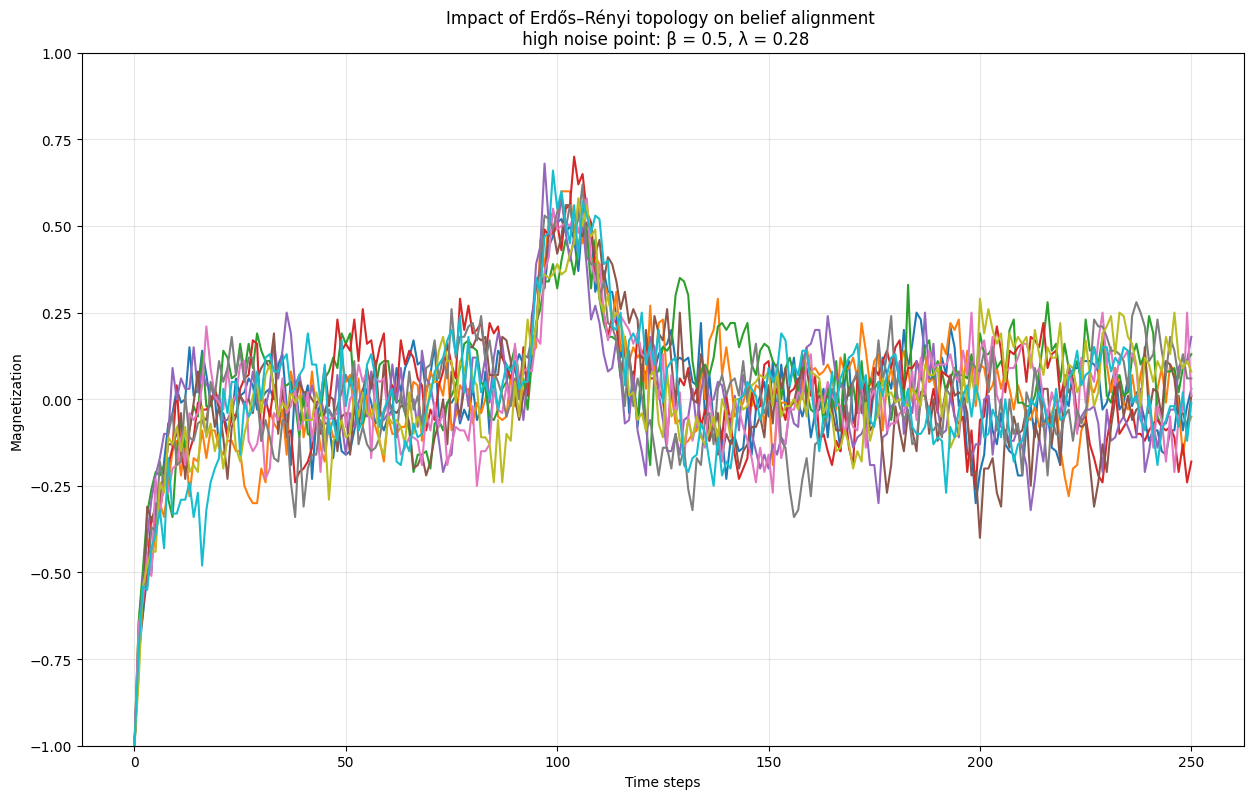

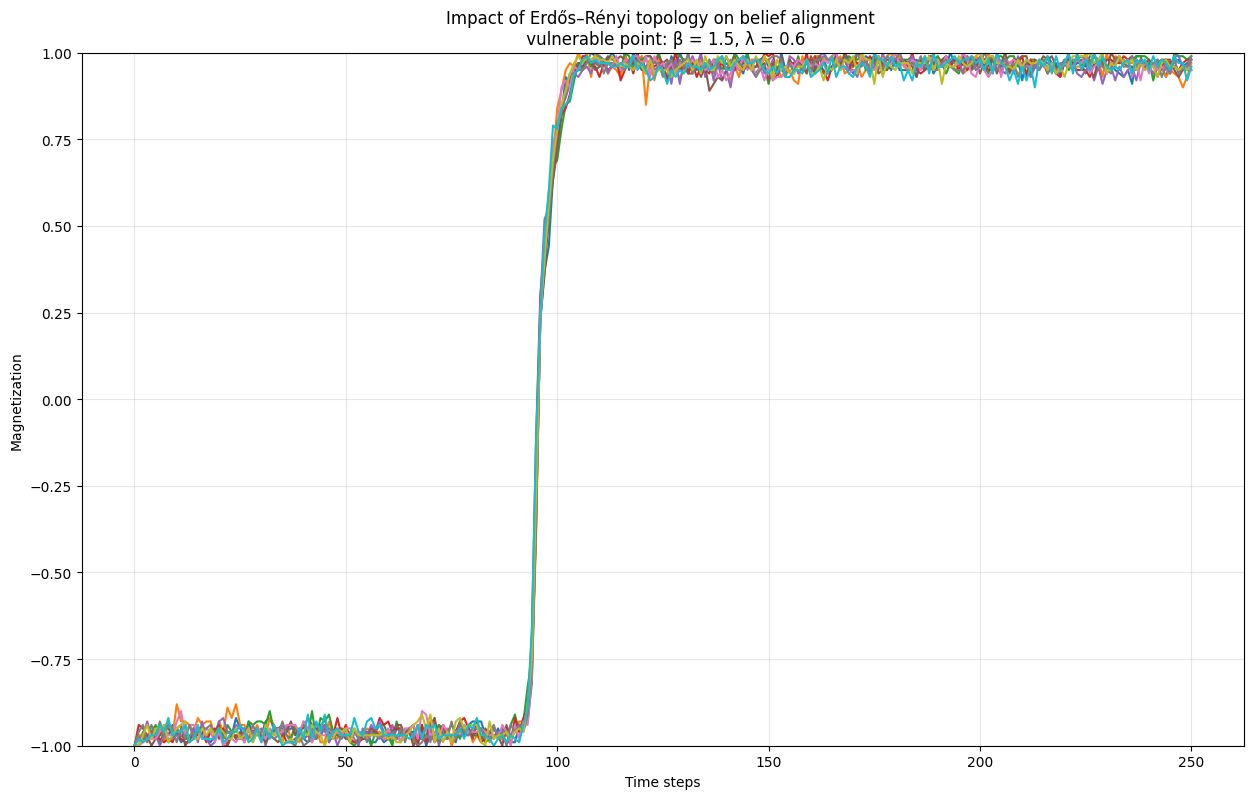

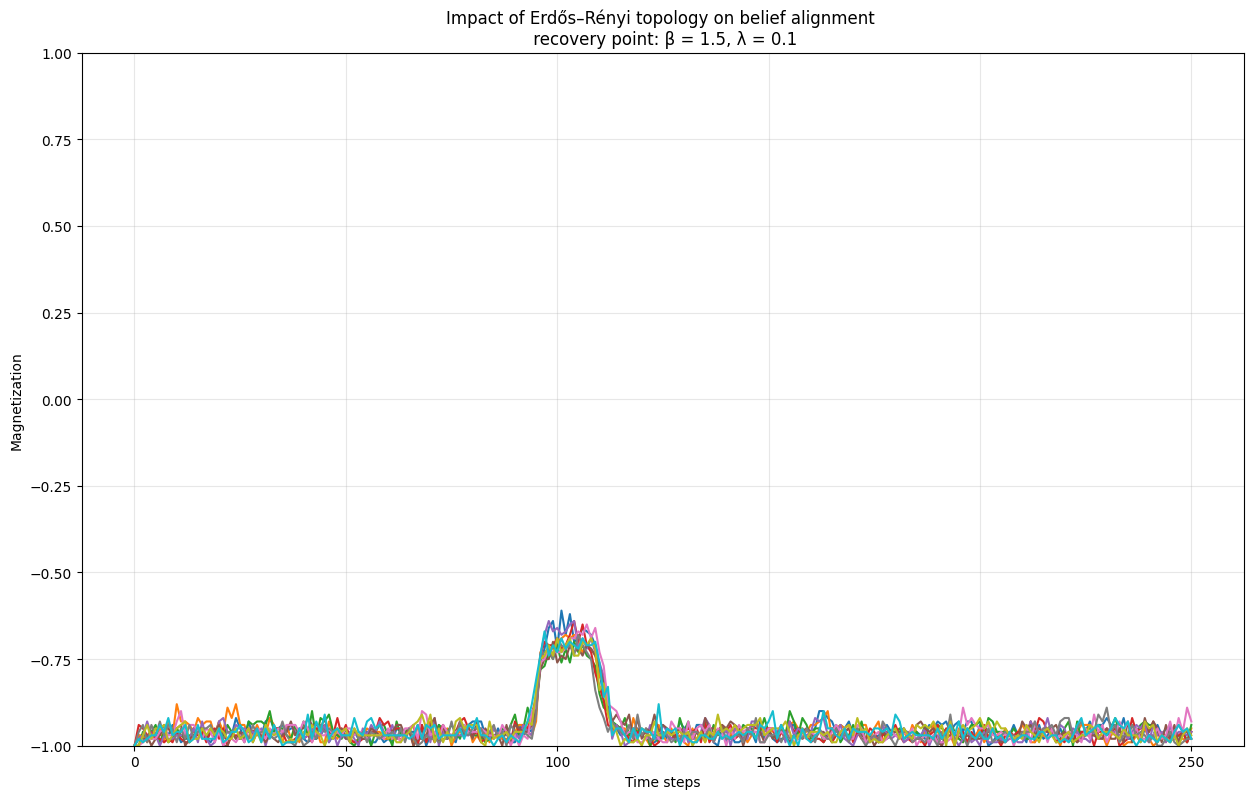

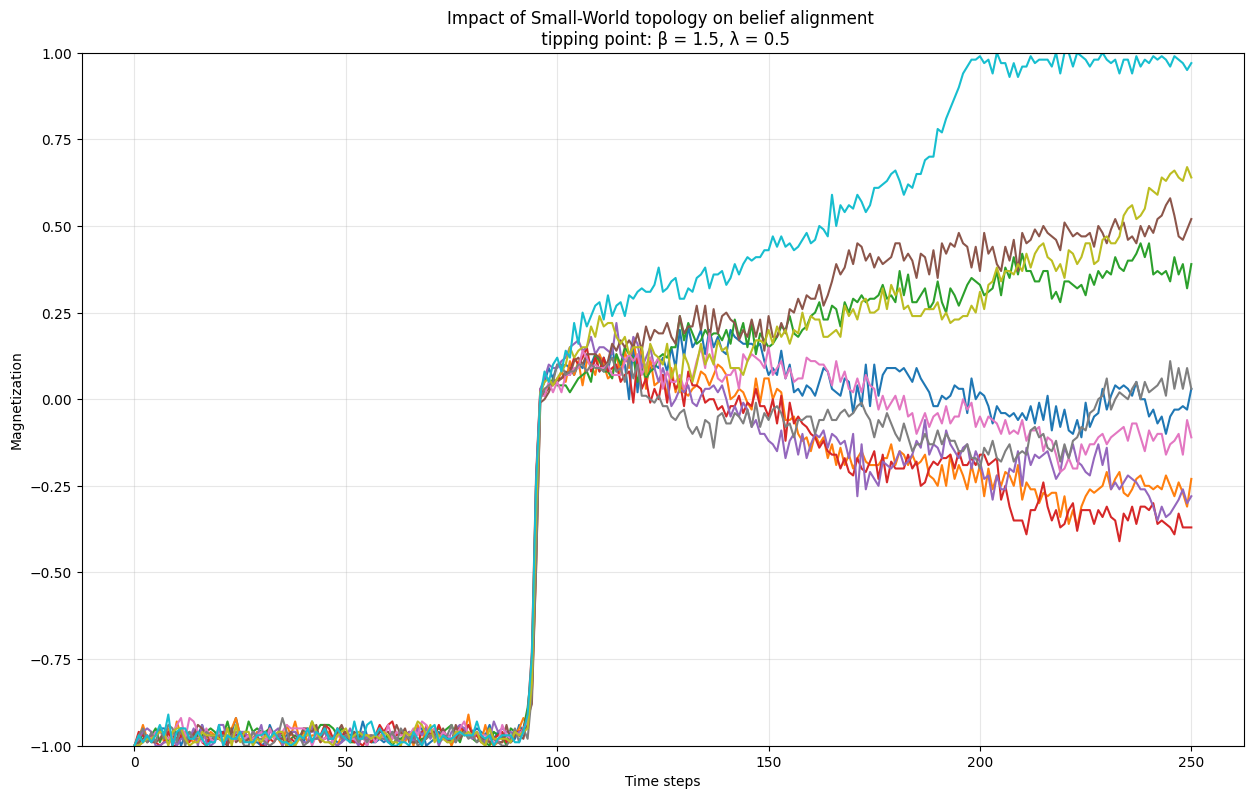

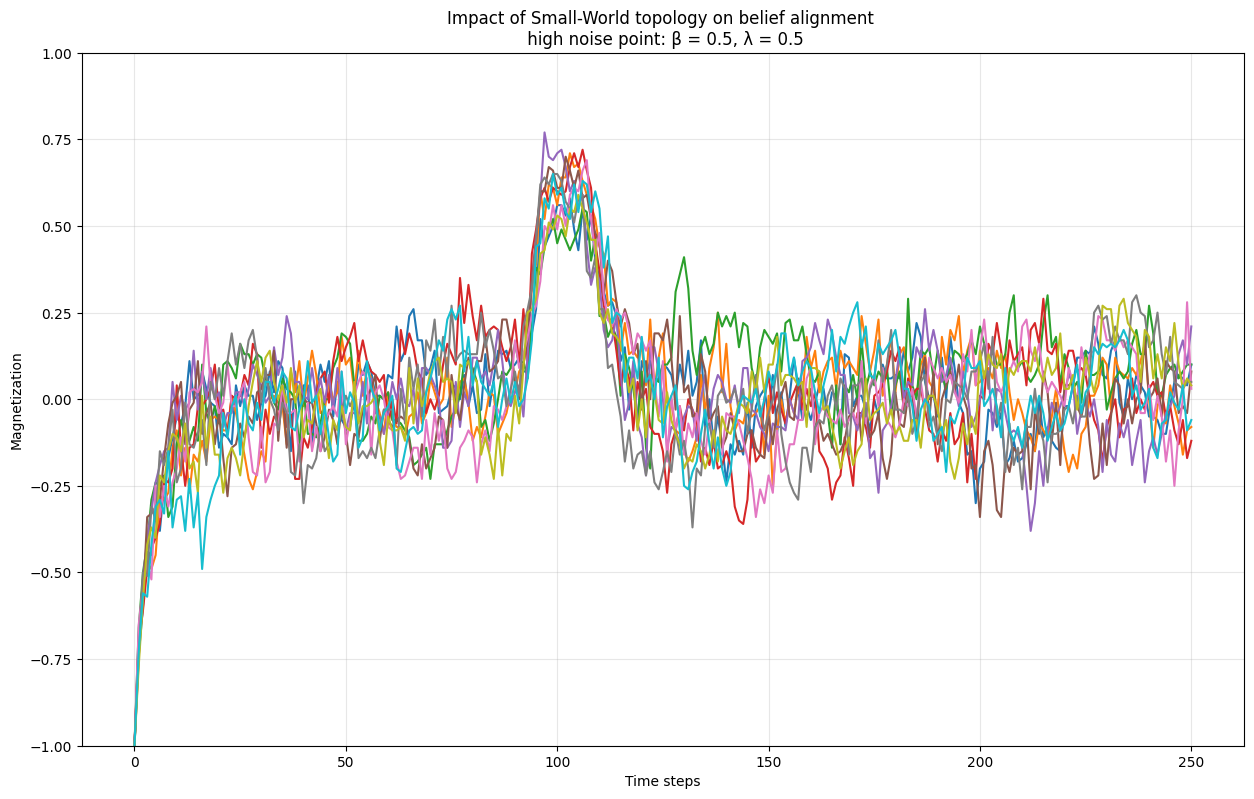

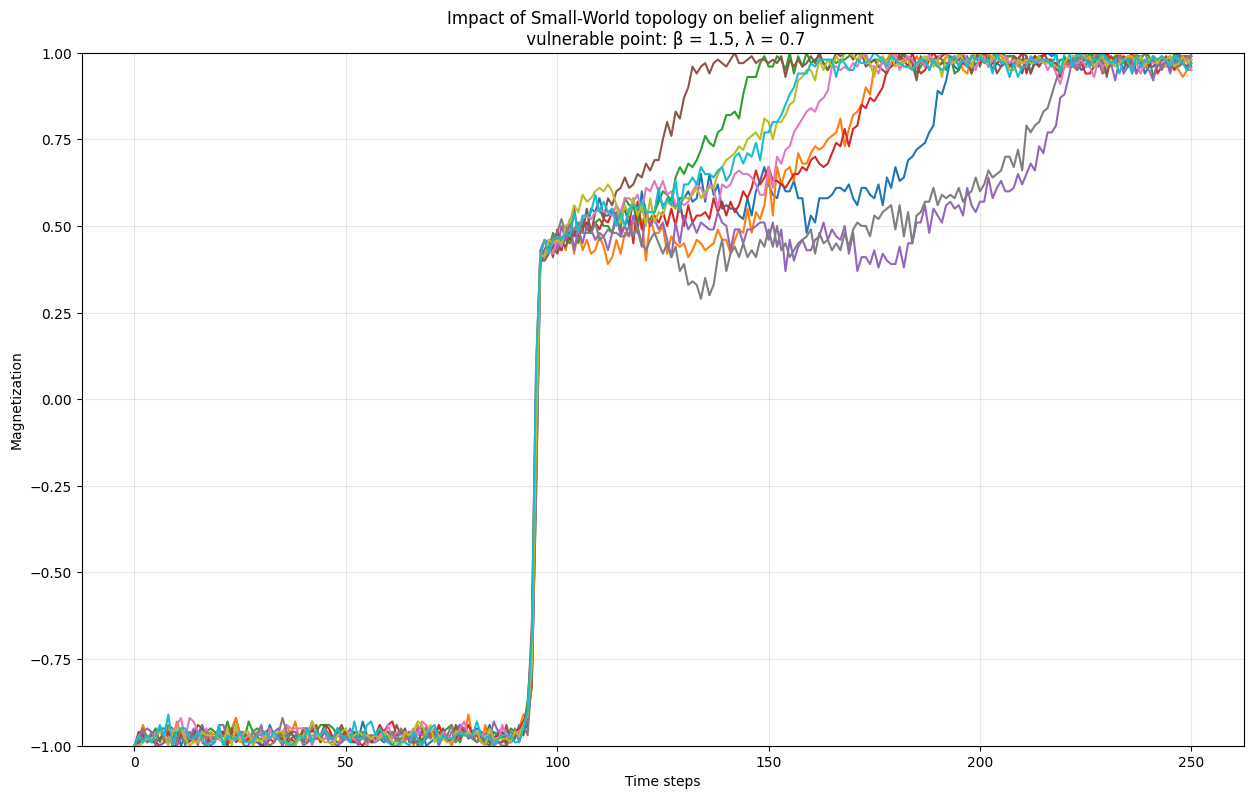

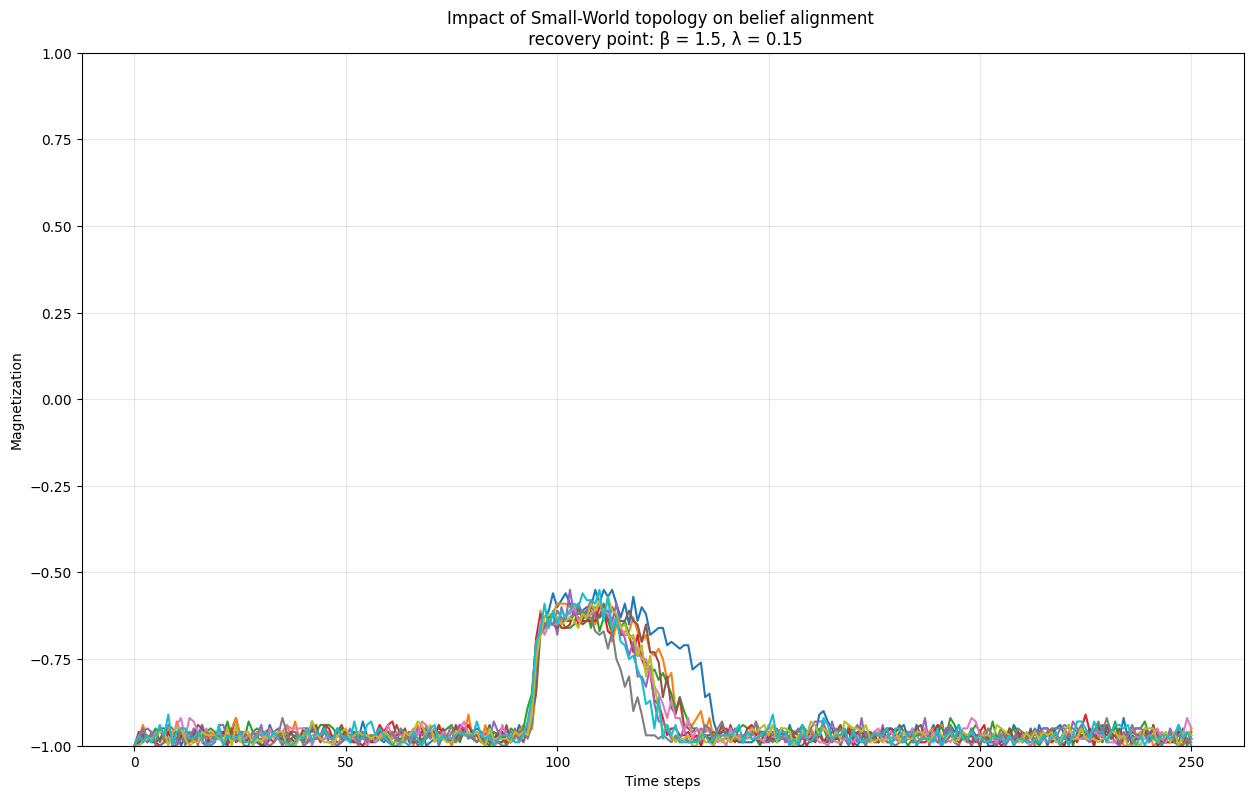

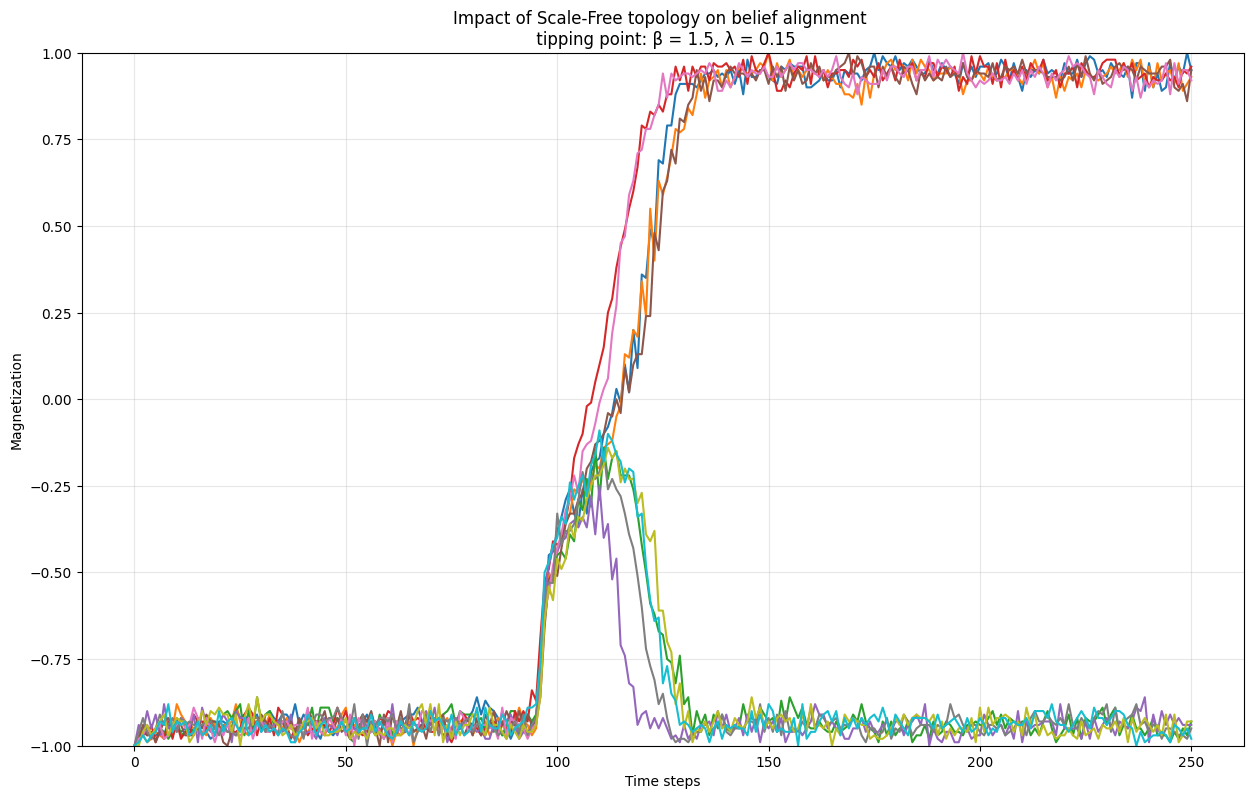

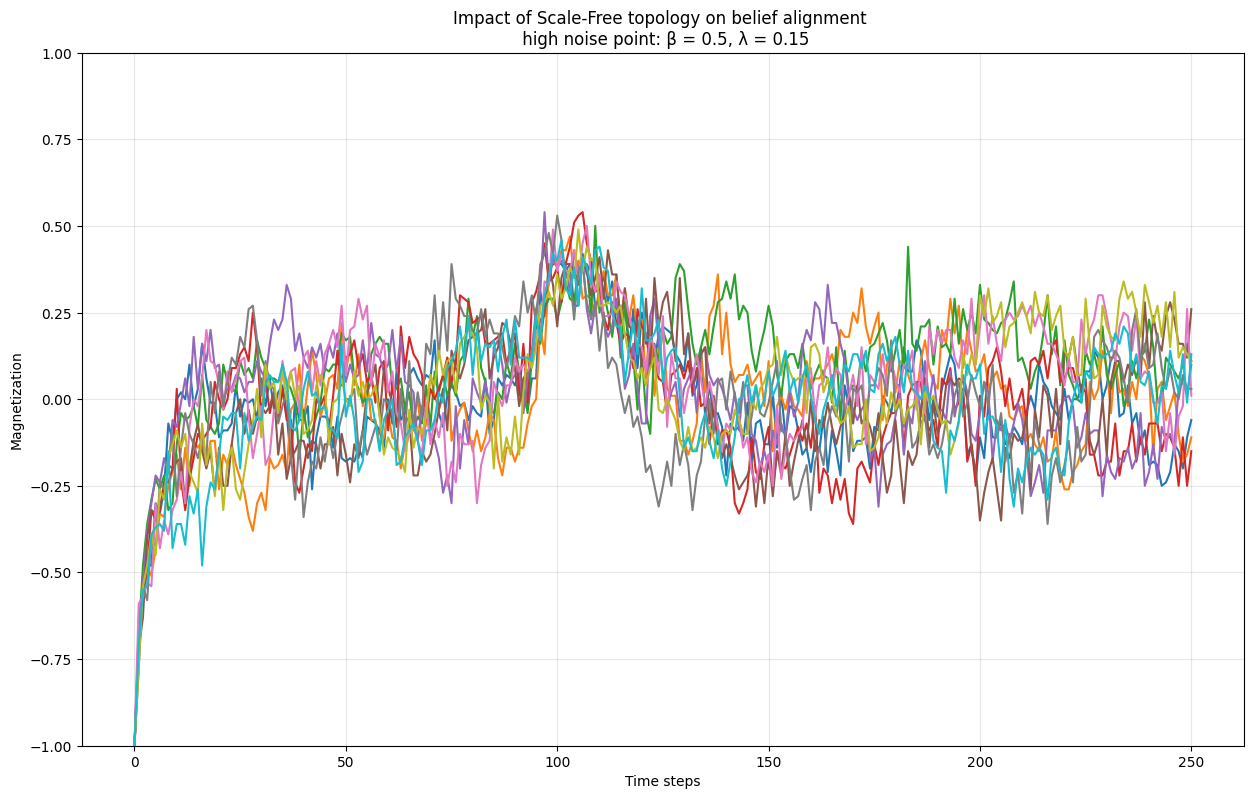

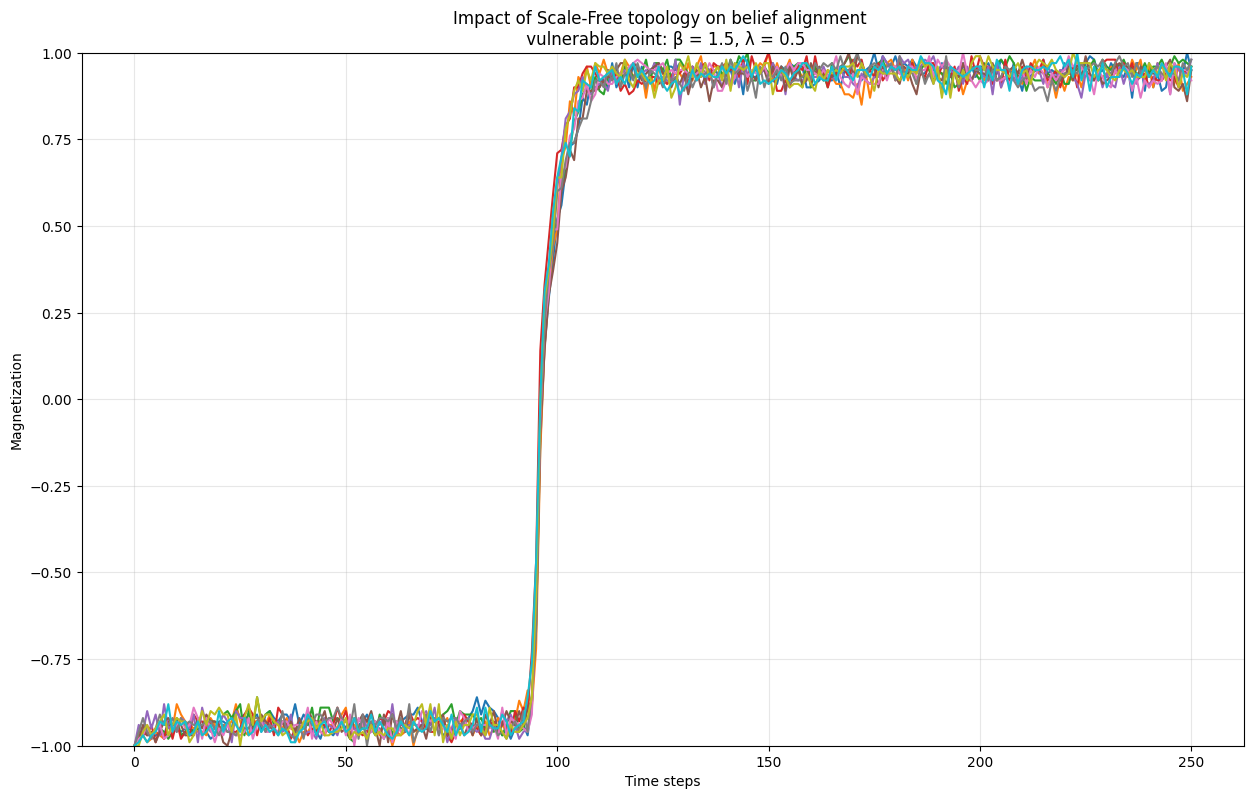

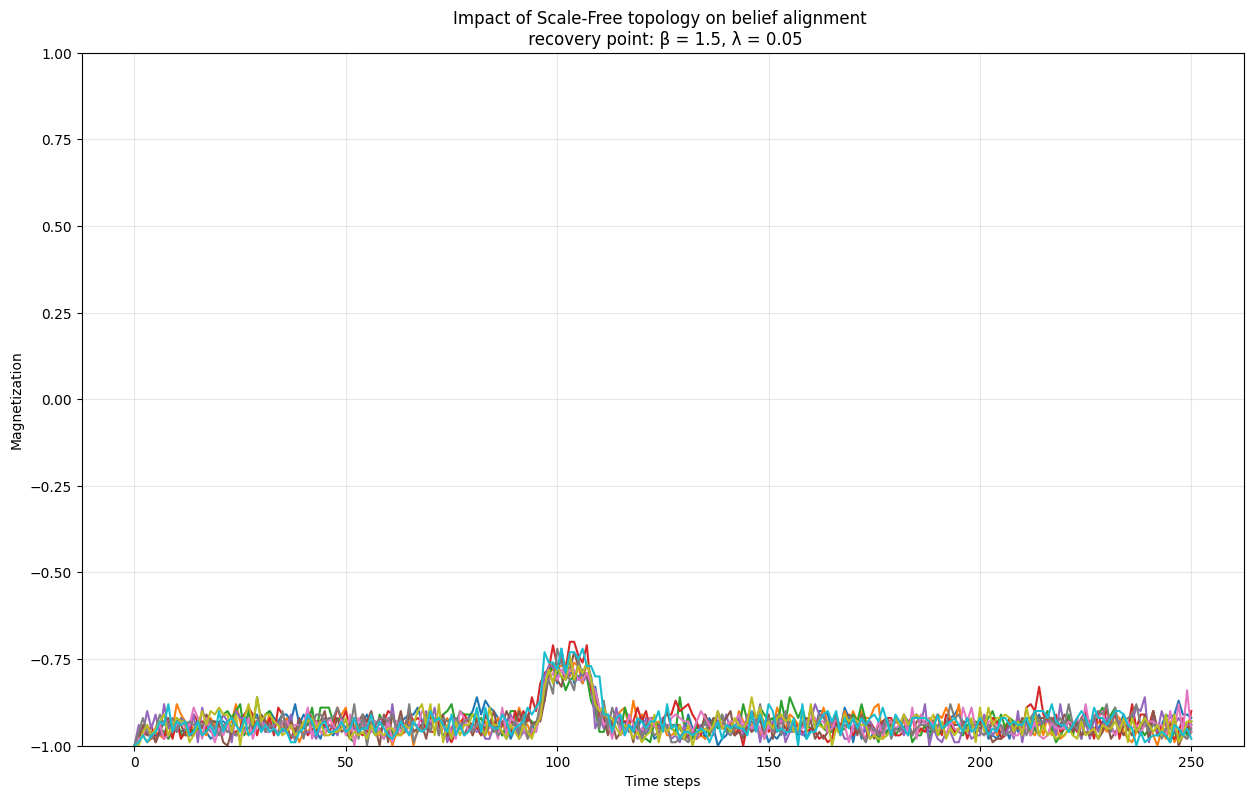

In [3]:
#network topology
topology = {"Erdős–Rényi":(network_generation.generate_erdos_renyi_sparse_adjacency_matrix,
    {"num_nodes": N, "edge_prob": edge_prob, "weight_range": weight_range}
    ),
    "Small-World": (
        network_generation.generate_small_world_sparse_adjacency_matrix_jax,
        {"num_nodes": N, "k": k_neighbours, "p": rewire_prob, "weight_range": weight_range}
    ),
    "Scale-Free": (
        network_generation.generate_scale_free_sparse_adjacency_matrix_jax,
        {"num_nodes": N, "num_edge": new_edges, "weight_range": weight_range}
    )}

# dictionary to store  mean magnetization of each topology
all_topology_means = {}

#  parameter sets for Erdos
parameter_sets_erdos = {
    "tipping": {"beta": 1.5, "l": 0.28}, #lambda - fraction of people being exposed to the dynamic field
    "high noise": {"beta": 0.5, "l": 0.28},
    "vulnerable": {"beta": 1.5, "l": 0.6},
    "recovery": {"beta": 1.5, "l": 0.1}
}
#  parameter sets
parameter_sets_scale_free = {
    "tipping": {"beta": 1.5, "l": 0.15},
    "high noise": {"beta": 0.5, "l": 0.15},
    "vulnerable": {"beta": 1.5, "l": 0.5},
    "recovery": {"beta": 1.5, "l": 0.05}
}
#  parameter set
parameter_sets_small_world = {
    "tipping": {"beta": 1.5, "l": 0.5},
    "high noise": {"beta": 0.5, "l": 0.5},
    "vulnerable": {"beta": 1.5, "l": 0.7},
    "recovery": {"beta": 1.5, "l": 0.15}
}

def simulation_topology(adj_mat, topology_name, param_name, beta, l):
    #initialisation 
    ones_init = jnp.negative(jnp.ones(shape=(len(adj_mat),)).astype(int)) #intitialisation with -1

    #external_field
    external_field = lambda t, node_idx: 10 * ((node_idx[0] / len(adj_mat)) < l) * (jnp.exp(-((t-alpha) / gamma)**2))

    mags = []
    for i in range(10):
        network = ising_efficient.BeliefNetwork(
            sparse_adj=adj_mat,
            external_field=external_field,
            init_state=ones_init, 
            µ=µ,
            beta=beta,
        )
        result = network.run_for_steps(250, seed=i)

        magnetization_erdos = np.mean(result, axis=1)
        mags.append(np.copy(magnetization_erdos))
    mags_array = np.array(mags)

    #plot 
    plt.figure(figsize=(15,9))
    for m in mags_array: 
        plt.plot(m)

    plt.xlabel("Time steps")
    plt.ylabel("Magnetization")
    plt.ylim(-1,1)
    plt.title(f"Impact of {topology_name} topology on belief alignment \n {param_name} point: β = {beta}, λ = {l}")
    plt.grid(True, alpha=0.3)
    filename = f"results/{topology_name.replace('-', '_')}_{param_name.replace(' ', '_')}.png"
    plt.savefig(filename)
    plt.show()

#plotting
for topology_name, (func, args) in topology.items():
    adj_mat = func(**args)
    if topology_name == 'Erdős–Rényi':
        for param_name, params in parameter_sets_erdos.items():
            simulation_topology(adj_mat, topology_name, param_name, **params)
    if topology_name == 'Small-World':
        for param_name, params in parameter_sets_small_world.items():
            simulation_topology(adj_mat, topology_name, param_name, **params)
    if topology_name == 'Scale-Free':
        for param_name, params in parameter_sets_scale_free.items():
            simulation_topology(adj_mat, topology_name, param_name, **params)


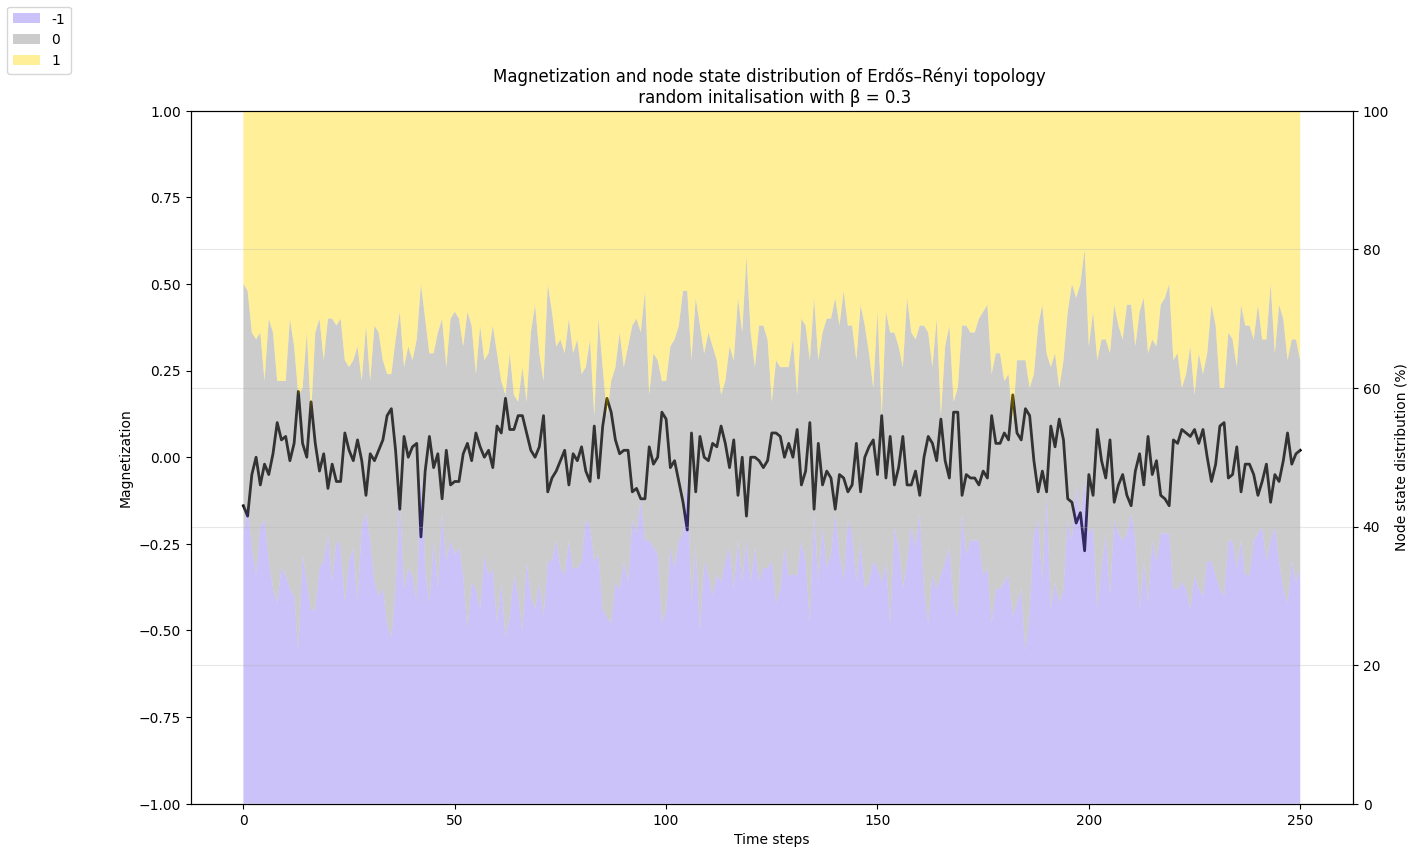

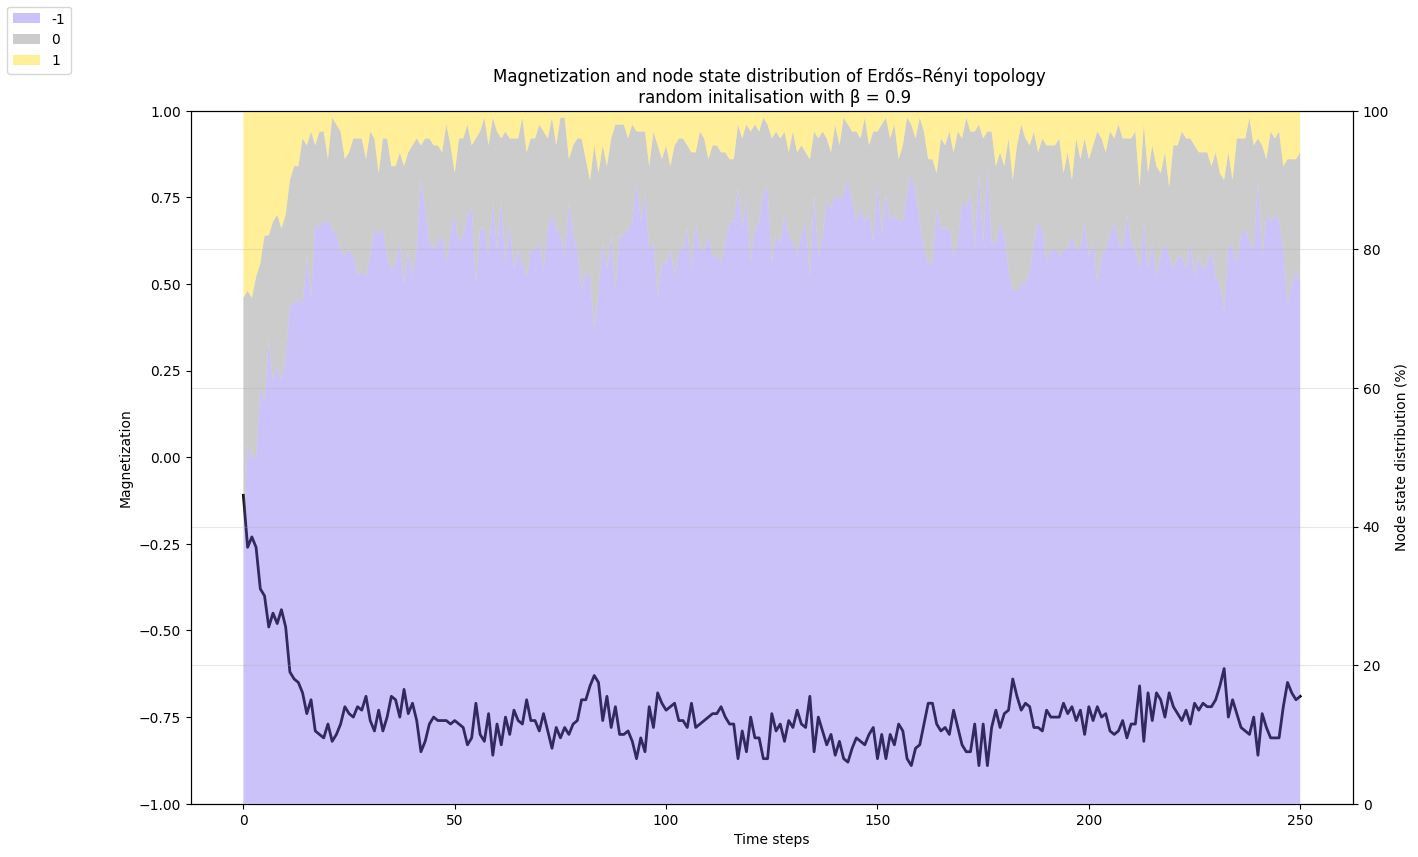

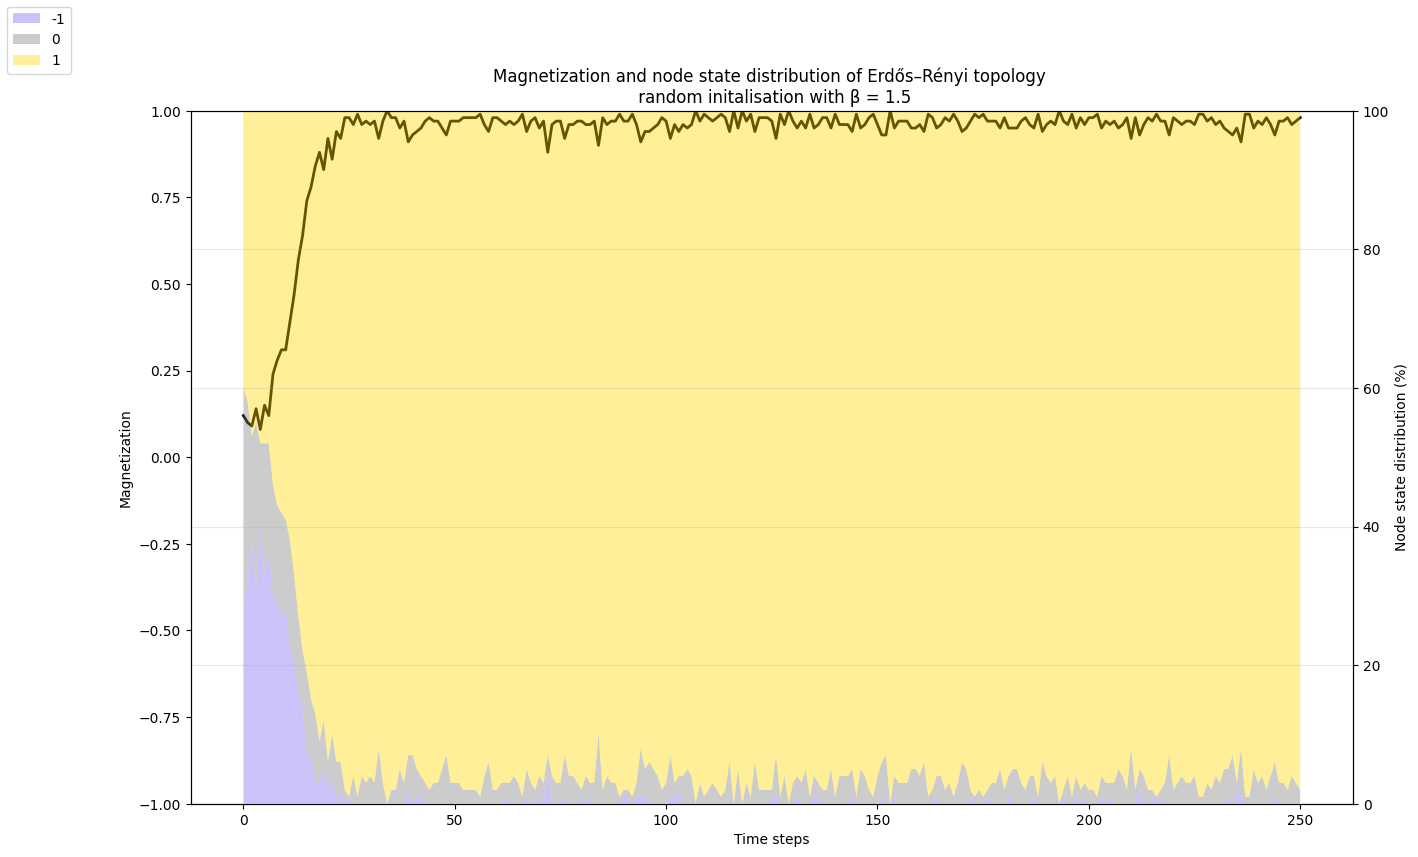

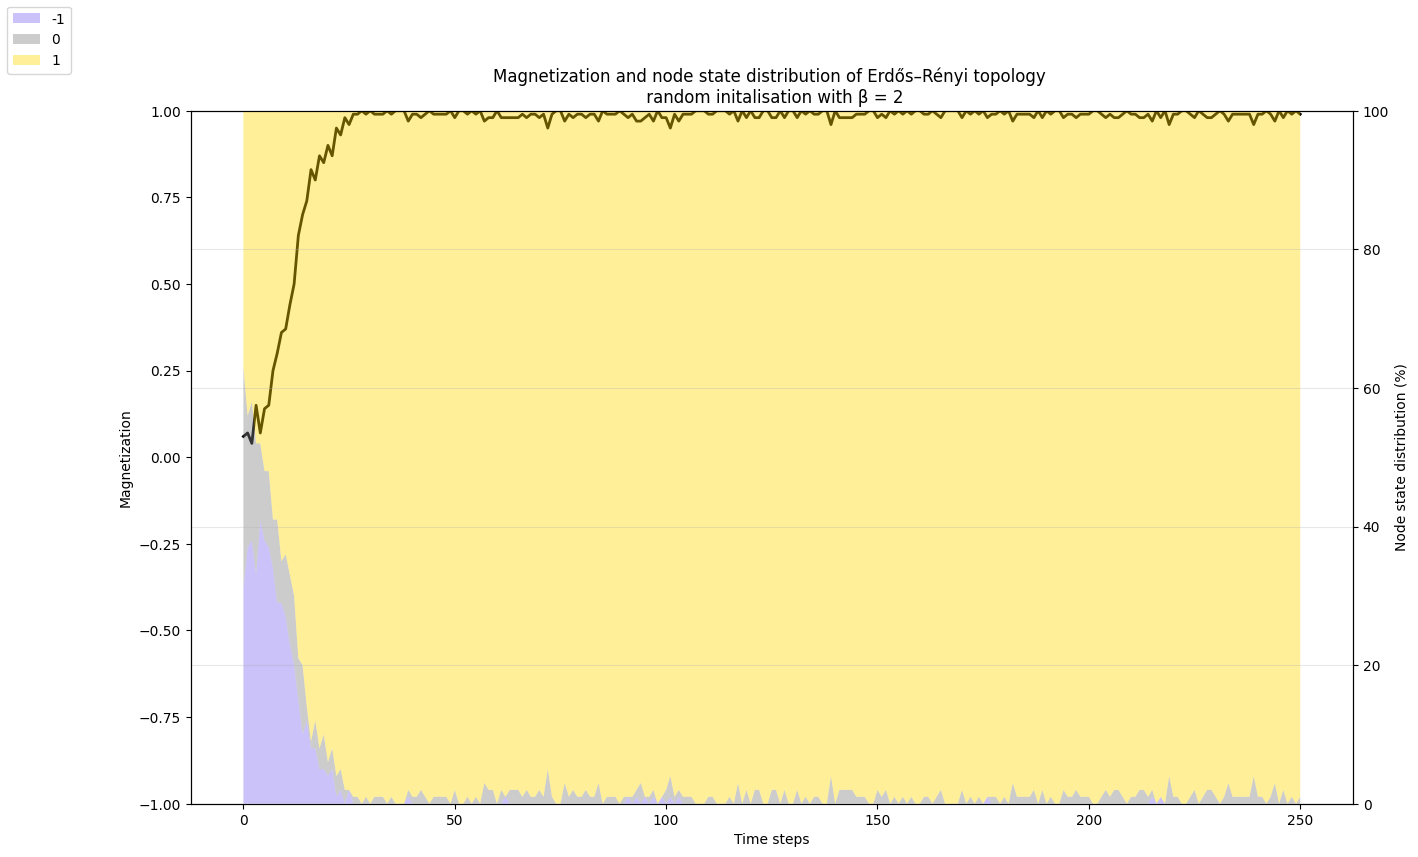

In [4]:
#  parameter sets for Erdos
parameter_sets_erdos = {
    "1": {"beta": 0.3, "l": 0},
    "2": {"beta": 0.9, "l": 0},
    "3": {"beta": 1.5, "l": 0},
    "4": {"beta": 2, "l": 0},
}

def simulation_no_external_field(adj_mat, topology_name, param_name, beta, l=0):
    #initialisation 
    results_list = []
    random_init = jax.random.randint(shape=(len(adj_mat),),minval=-1,maxval=2,key=jax.random.PRNGKey(np.random.randint(low=0, high=100000)),)
    
    network = ising_efficient.BeliefNetwork(
        sparse_adj=adj_mat,
        external_field=lambda t, node_idx: 0,
        init_state=np.copy(random_init),
        µ=µ,
        beta=beta,
    )
    result = network.run_for_steps(250, seed=0)
    results_list.append(np.array(result))

    magnetization_erdos = np.mean(result, axis=1)
    
    #results for the stackchart
    first_result = results_list[0]  # shape: (timesteps, n_nodes)
    time_steps = np.arange(first_result.shape[0])
    counts_neg = np.sum(first_result == -1, axis=1)
    counts_zero = np.sum(first_result == 0, axis=1)
    counts_pos = np.sum(first_result == 1, axis=1)

    #plot
    fig, ax1 = plt.subplots(figsize=(15,9))
     #trajectory
    ax1.plot(magnetization_erdos, color = 'black', linewidth =2)
    ax1.set_ylabel("Magnetization")
    ax1.set_ylim(-1, 1)
    ax1.set_xlabel("Time steps")
    #stacked bacground counts
    ax2 = ax1.twinx()
    ax2.stackplot(time_steps, counts_neg, counts_zero, counts_pos, labels=['-1','0','1'], colors=['mediumslateblue','grey','gold'], alpha=0.4),
    ax2.set_ylabel("Node state distribution (%)")
    ax2.set_ylim(0, 100)
    fig.legend(loc='outside upper left')

    plt.title(f"Magnetization and node state distribution of {topology_name} topology \n random initalisation with β = {beta}")
    plt.grid(True, alpha=0.3)
 
    filename = f"results/random_{topology_name.replace('-', '_')}_{param_name}.png"
    plt.savefig(filename)
    plt.show()

#plotting
for topology_name, (func, args) in topology.items():
    adj_mat = func(**args)
    if topology_name == 'Erdős–Rényi':
        for param_name, params in parameter_sets_erdos.items():
            simulation_no_external_field(adj_mat, topology_name, param_name, **params)

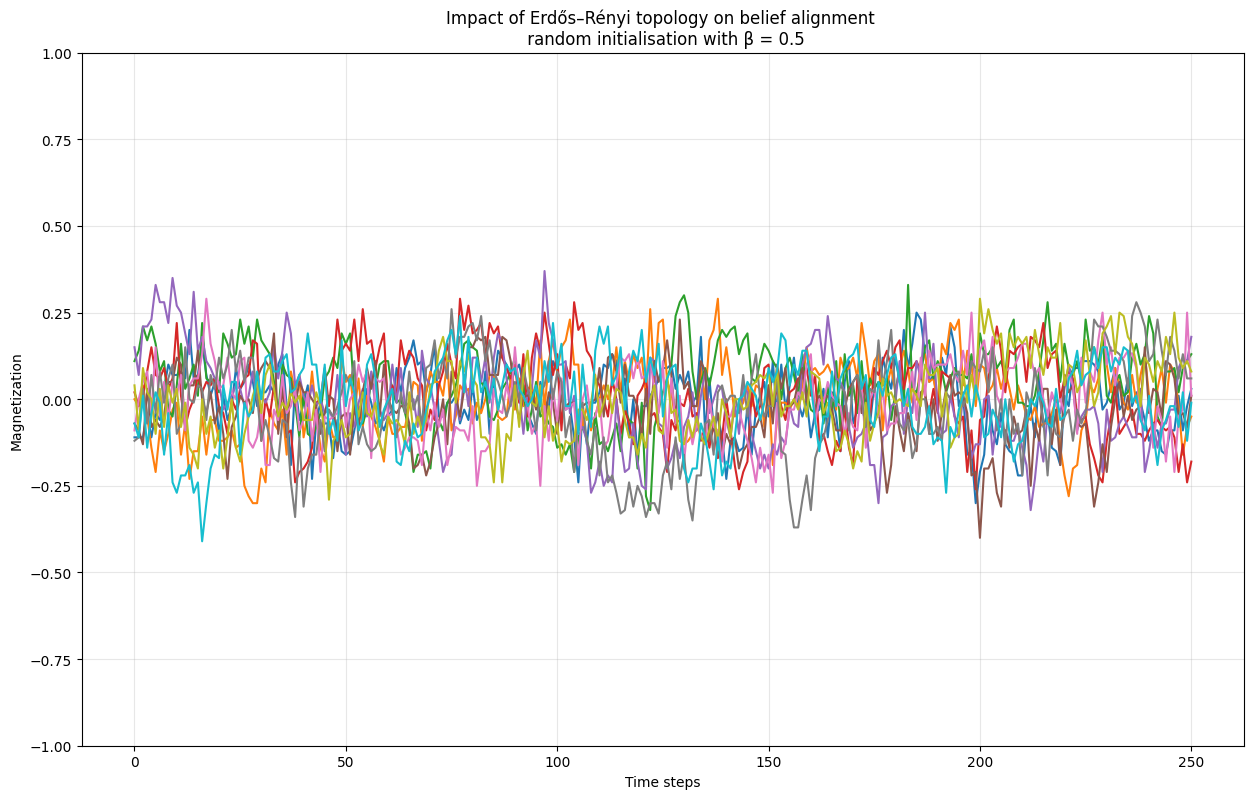

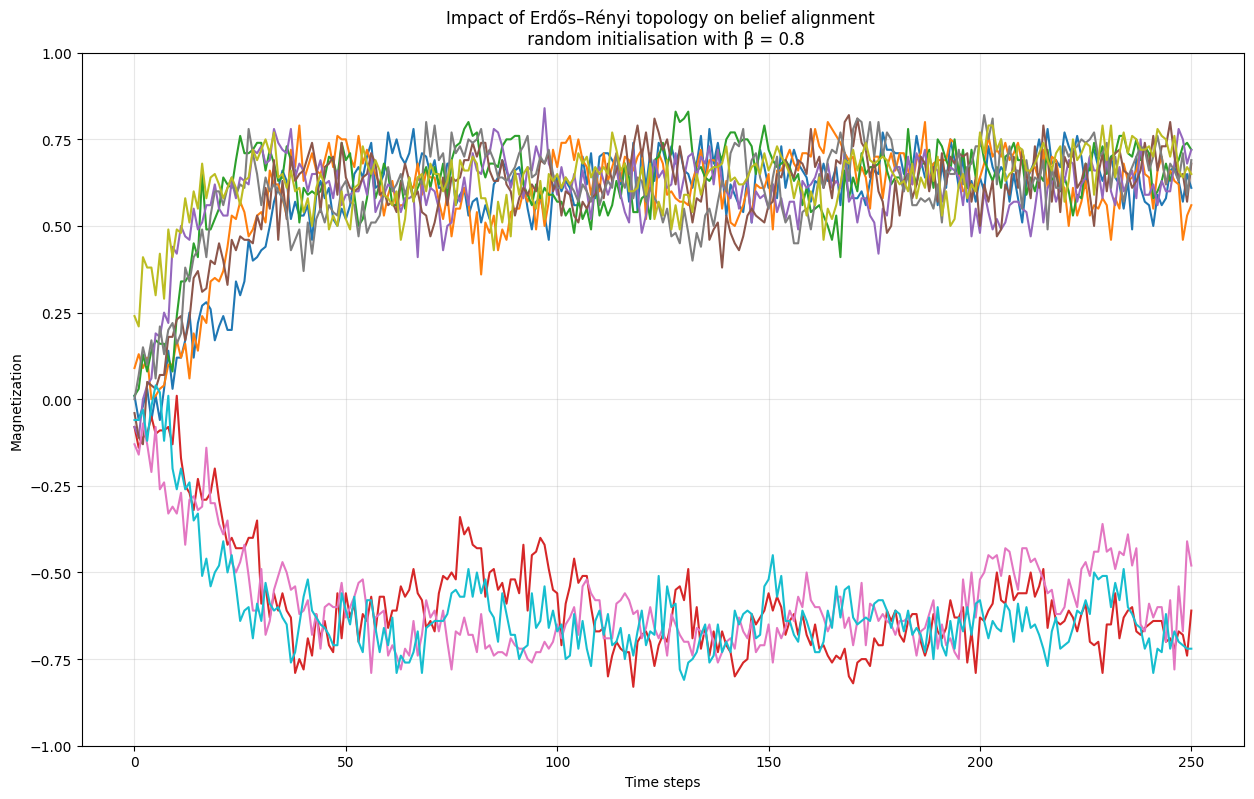

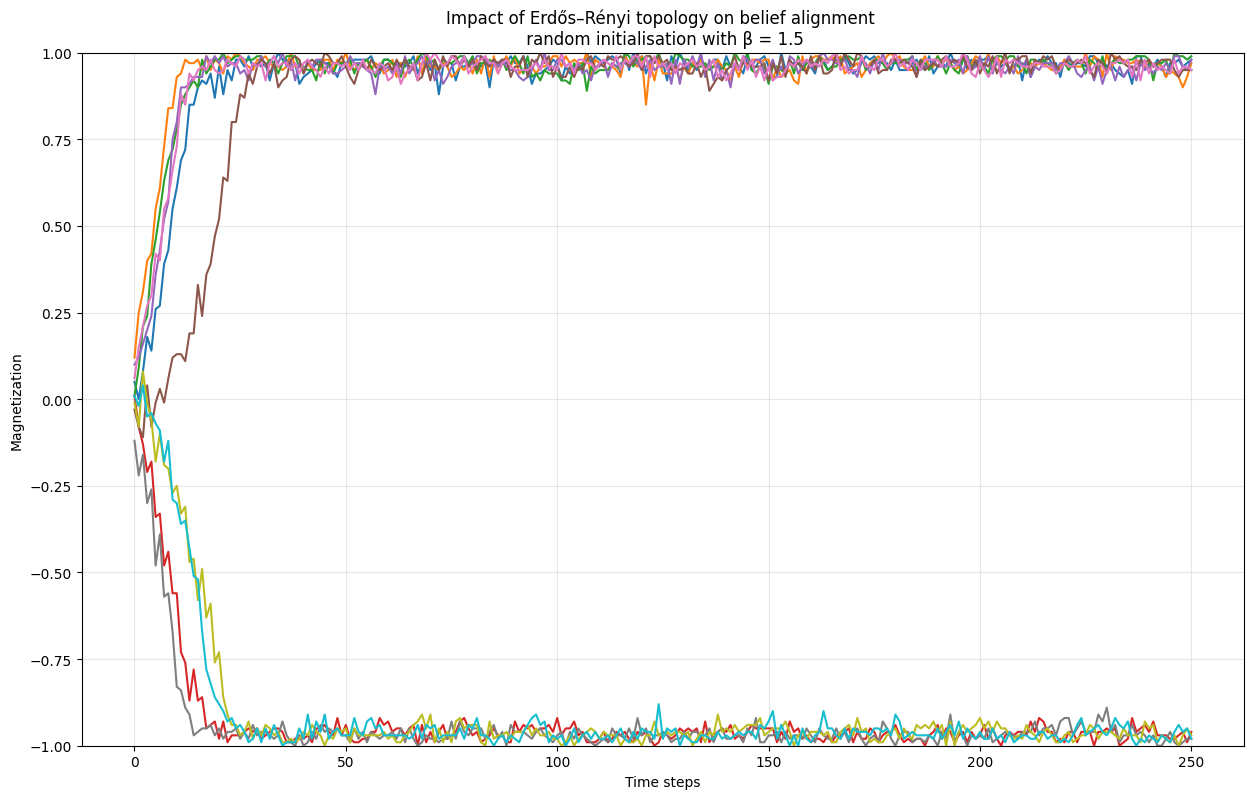

In [5]:
#  parameter sets for Erdos
parameter_sets_erdos = {
    "1": {"beta": 0.5, "l": 0},
    "2": {"beta": 0.8, "l": 0},
    "3": {"beta": 1.5, "l": 0},
}
mags = []
def simulation_no_external_field(adj_mat, topology_name, param_name, beta, l=0):
    #initialisation 
    
    mags = []
    for i in range(10):
        random_init = jax.random.randint(shape=(len(adj_mat),),minval=-1,maxval=2,key=jax.random.PRNGKey(np.random.randint(low=0, high=100000)),)
        network = ising_efficient.BeliefNetwork(
            sparse_adj=adj_mat,
            external_field=lambda t, node_idx: 0,
            init_state=np.copy(random_init),
            µ=µ,
            beta=beta,
        )
        result = network.run_for_steps(250, seed=i)

        magnetization_erdos = np.mean(result, axis=1)
        mags.append(np.copy(magnetization_erdos))
    mags_array = np.array(mags)

    plt.figure(figsize=(15,9))
    for m in mags_array: 
        plt.plot(m)

    plt.xlabel("Time steps")
    plt.ylabel("Magnetization")
    plt.ylim(-1,1)
    plt.title(f"Impact of {topology_name} topology on belief alignment \n random initialisation with β = {beta}")
    plt.grid(True, alpha=0.3)
    #plt.legend()
    filename = f"results/random_multiple_{topology_name.replace('-', '_')}_{param_name}.png"
    plt.savefig(filename)
    plt.show()

#plotting
for topology_name, (func, args) in topology.items():
    adj_mat = func(**args)
    if topology_name == 'Erdős–Rényi':
        for param_name, params in parameter_sets_erdos.items():
            simulation_no_external_field(adj_mat, topology_name, param_name, **params)